In [26]:
import pandas as pd
import scanpy as sc
import numpy as np
import anndata as ad
import random

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
from sklearn import preprocessing as pp

In [27]:
data_folder = '/dss/dsshome1/lxc07/gobi009/data/'

In [28]:
path_human_healthy = data_folder + 'P21000/'
path_upr = data_folder + 'GSE114297/'
path_human_spikein_drug = data_folder + 'GSE142465_human/'

### Load annotations

In [29]:
# Load annotation for human healthy
adata_hh = sc.read_h5ad(path_human_healthy + 'data_annotated.h5ad')

In [30]:
hh_samples = ['114_human_islets_R266_74_years', 'HI_24', 'HI_61', 'HI_63', 'Human_Islet']

In [31]:
# Load annotation for upr
adata_upr = sc.read_h5ad(path_upr + 'data_annotated.h5ad')

In [32]:
upr_samples = ['Donor_1', 'Donor_2', 'Donor_3', 'Donor_4', 'Donor_5', 'Donor_6', 'Donor_7', 'Donor_8', 'Donor_9', 'Donor_10', 'Donor_11', 'Donor_12']

In [33]:
# Load annotation for human spikein drug
adata_hsd = sc.read_h5ad(path_human_spikein_drug + 'data_annotated.h5ad')

In [34]:
hsd_samples = ['SRR10751484', 'SRR10751489', 'SRR10751497', 'SRR10751498', 'SRR10751499', 'SRR10751500', 'SRR10751501']

### Concatenating and filtering the three data sets

In [35]:
# Concatenate the data sets
adata = ad.concat([adata_hh, adata_upr, adata_hsd])
del adata_hh
del adata_upr
del adata_hsd

In [36]:
ct_col = 'cell_type'

In [37]:
# Filter for healthy samples and beta cells
adata = adata[adata.obs['file'].isin(hh_samples + upr_samples + hsd_samples)]

In [38]:
# Load metadata for the project
metadata_hh = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_healthy')
metadata_upr = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='UPR')
metadata_hsd = pd.read_excel('/dss/dsshome1/lxc07/gobi009/data/scRNA-seq_pancreas_metadata.xlsx',
             sheet_name='human_spikein_drug')

In [39]:
# Filter out removed samples
metadata_hh = metadata_hh[metadata_hh['sample_name'].isin(hh_samples)]
metadata_upr = metadata_upr[metadata_upr['sample_name'].isin(upr_samples)]
metadata_hsd = metadata_hsd[metadata_hsd['sample_name'].isin(hsd_samples)]

# Subset data frames to required columns
metadata_hh = metadata_hh[['sample_name', 'sex', 'age']]
metadata_upr = metadata_upr[['sample_name', 'sex', 'age']]
metadata_hsd = metadata_hsd[['sample_name', 'sex', 'age']]

# Add study name to data frames
metadata_hh['study'] = ['human_healthy' for _ in range(metadata_hh.shape[0])]
metadata_upr['study'] = ['UPR' for _ in range(metadata_upr.shape[0])]
metadata_hsd['study'] = ['human_spikein_drug' for _ in range(metadata_hsd.shape[0])]

# Concatenate data frames
metadata = pd.concat([metadata_hh, metadata_upr, metadata_hsd])

In [40]:
# capture removes warning from anndata
# Add age, sex and study to adata.obs (renaming just for the looks)
adata.obs.rename(columns={'file': 'sample_name'}, inplace=True)
merged_obs = pd.merge(adata.obs, metadata, on='sample_name')
merged_obs.index = adata.obs.index
adata.obs = merged_obs

In [41]:
# Remove the y from the age column
adata.obs['age'] = adata.obs['age'].map(lambda a: a.split(' ')[0])

In [42]:
adata.shape

(90374, 14977)

In [43]:
adata.obs

,sample_name,n_counts,n_genes,mt_frac,n_counts_filter,n_genes_filter,mt_frac_filter,doublet_score,doublet,doublet_score_filter,size_factors,leiden,cell_type,cluster,cell_type_multiplet,sex,age,study
index,,,,,,,,,,,,,,,,,,
AAACCTGAGACAAAGG-1-HI_24,HI_24,19372.0,3136,0.092350,ok,ok,ok,0.026517,0,ok,1.016746,11,beta,17,beta,female,24,human_healthy
AAACCTGAGACACGAC-1-HI_24,HI_24,13690.0,3347,0.047480,ok,ok,ok,0.028359,0,ok,1.004483,3,alpha,4,alpha,female,24,human_healthy
AAACCTGAGTCCGGTC-1-HI_24,HI_24,12112.0,3197,0.051354,ok,ok,ok,0.055249,0,ok,0.946407,3,alpha,4,alpha,female,24,human_healthy
AAACCTGCACTTAACG-1-HI_24,HI_24,11681.0,3120,0.055303,ok,ok,ok,0.007178,0,ok,0.890676,6,delta,12,delta,female,24,human_healthy
AAACCTGGTACGACCC-1-HI_24,HI_24,23595.0,4477,0.116253,ok,ok,ok,0.023177,0,ok,1.757859,1,beta,6,beta,female,24,human_healthy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGTCGG-1-SRR10751498,SRR10751498,4153.0,1299,0.025765,ok,ok,ok,0.070423,0,ok,0.523244,0,alpha,0,alpha,male,37,human_spikein_drug
TTTGTCAGTAAGAGGA-1-SRR10751498,SRR10751498,3708.0,1237,0.044229,ok,ok,ok,0.056652,0,ok,0.446222,0,alpha,0,alpha,male,37,human_spikein_drug
TTTGTCAGTCTCTTAT-1-SRR10751498,SRR10751498,2489.0,1258,0.033347,ok,ok,ok,0.010193,0,ok,0.468760,2,ductal,2,ductal,male,37,human_spikein_drug


In [44]:
random.choice(adata.var.index.unique().tolist())

'LRRC56'

In [45]:
genes = ['CARTPT']
score_name = 'cartpt'

In [46]:
# Compute score
sc.tl.score_genes(adata, gene_list=genes, score_name=score_name + '_score', use_raw=False)

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_26346/2457524397.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])


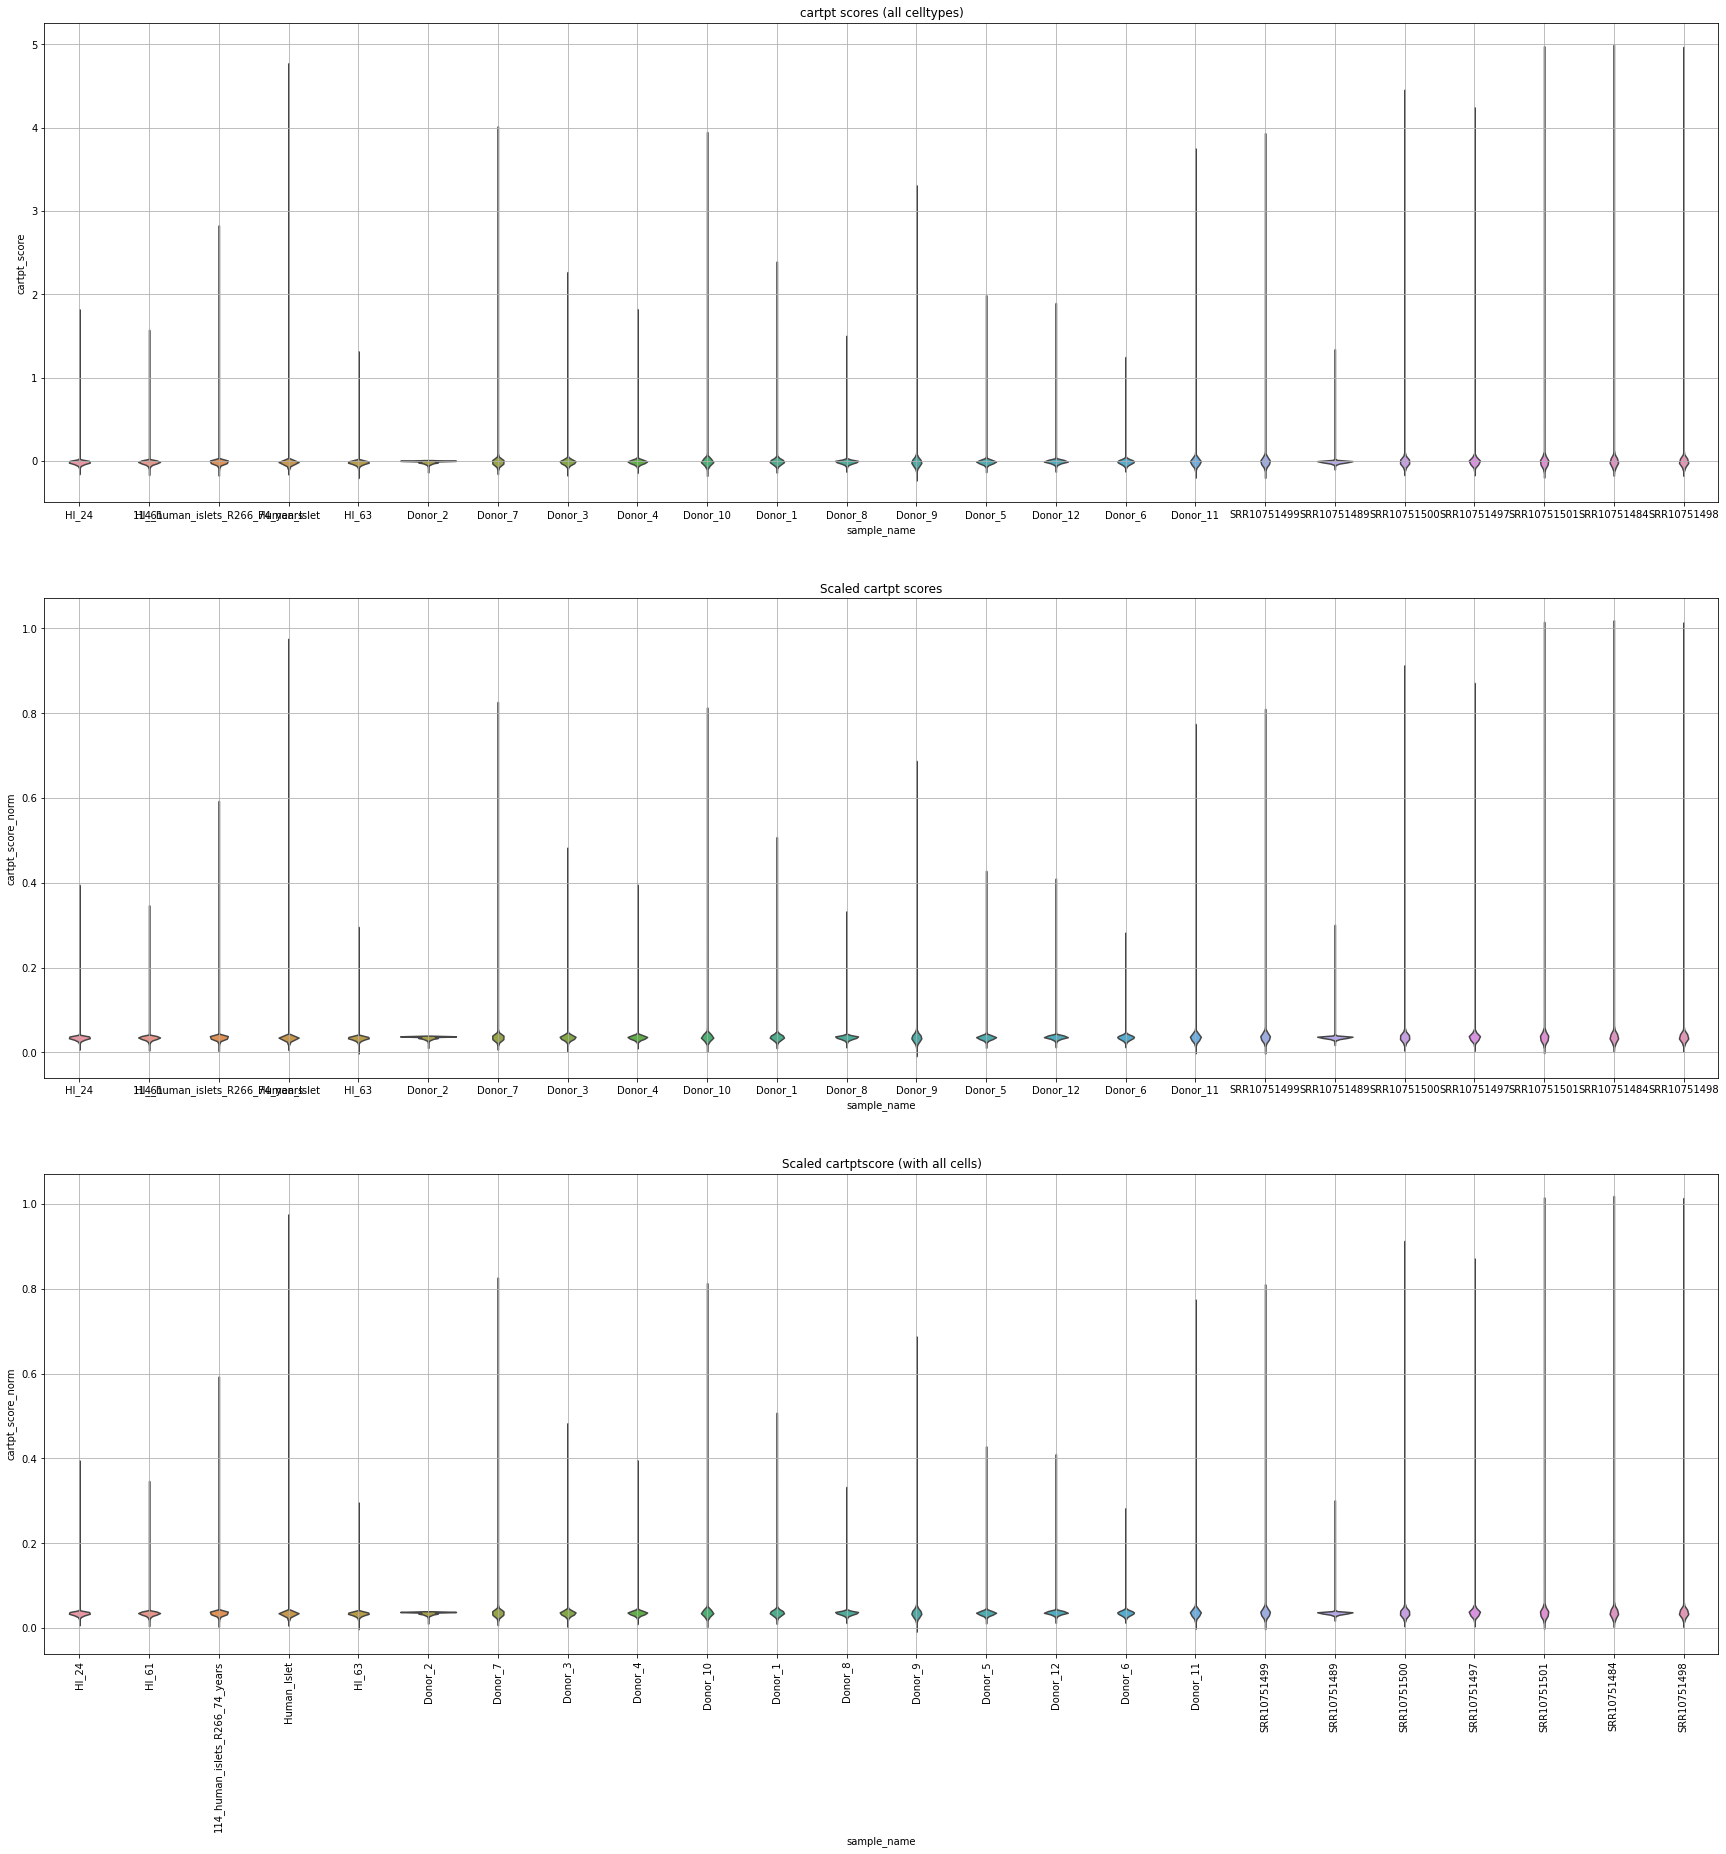

In [47]:
scores = adata.obs[[score_name + '_score','sample_name']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (30, 30)
fig, axs = plt.subplots(3, 1)
plt.xticks(rotation = 90)
sb.violinplot(x='sample_name', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores (all celltypes)')
axs[0].grid()
sb.violinplot(x='sample_name', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name + ' scores')
axs[1].grid()
sb.violinplot(x='sample_name', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > -10], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + 'score (with all cells)')
axs[2].grid()

In [48]:
adata_beta = adata[adata.obs['cell_type'] == 'acinar'].copy()

In [49]:
# Compute score
sc.tl.score_genes(adata_beta, gene_list=genes, score_name=score_name + '_score', use_raw=False)

/dss/dsshome1/lxc07/gobi009/miniconda3/envs/block/lib/python3.8/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


/gpfs/scratch/pn25xo/gobi009/gobi009/ipykernel_26346/2928409739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])


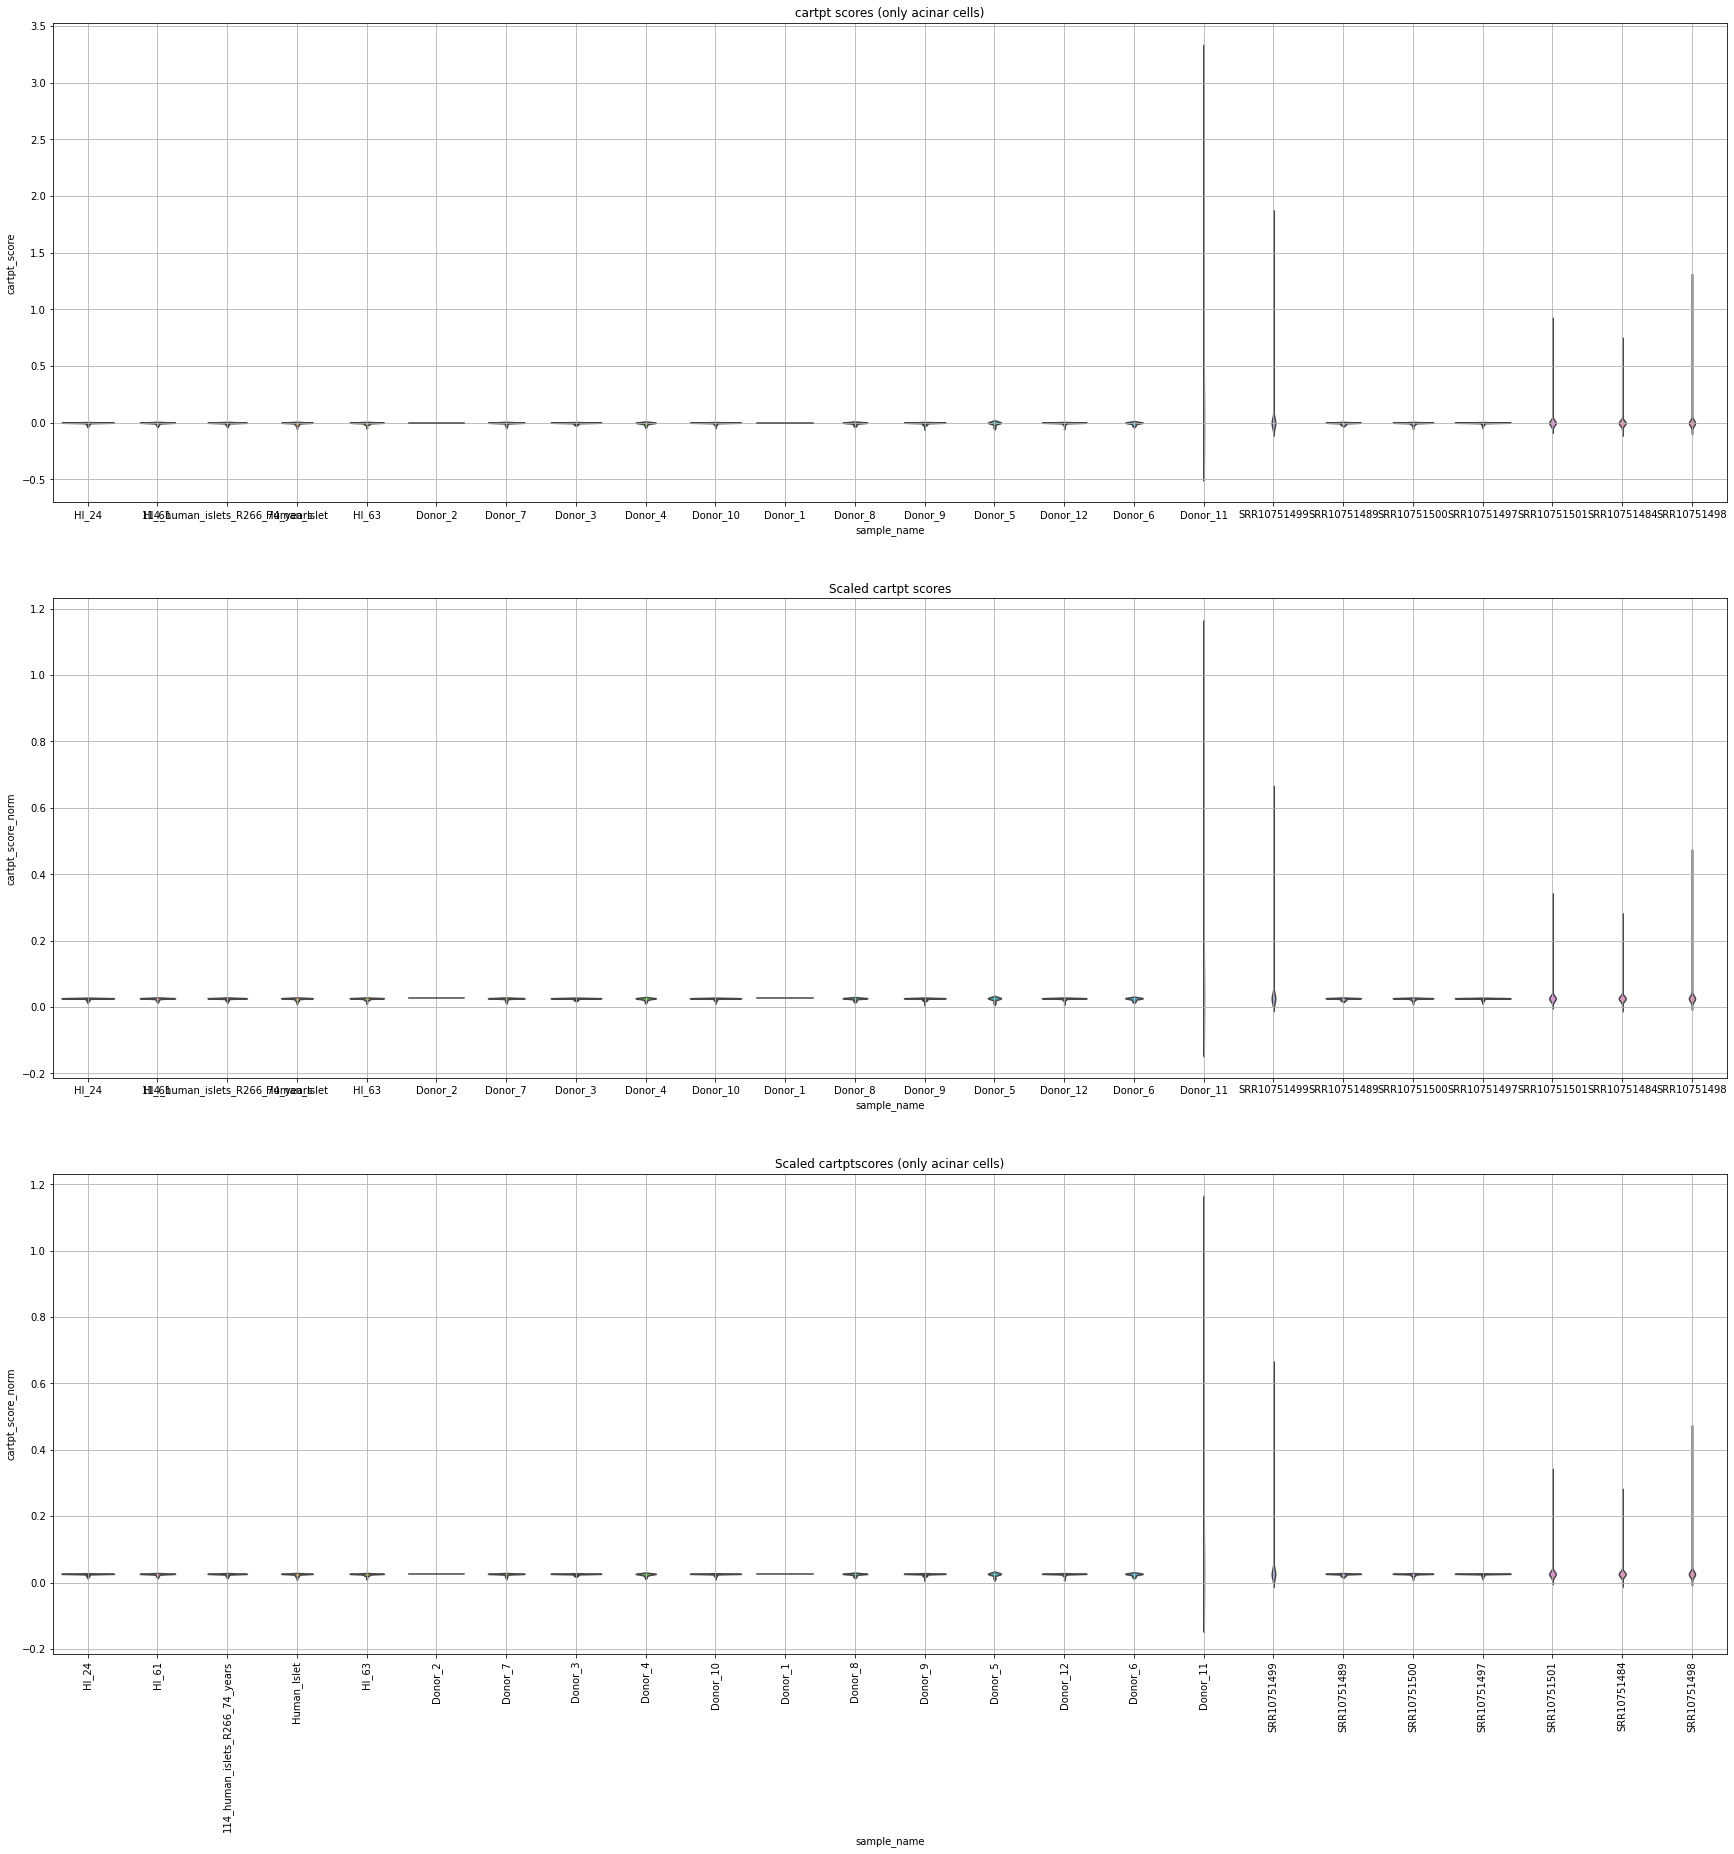

In [50]:
scores = adata_beta.obs[[score_name + '_score','sample_name']]
scores[score_name + '_score_norm'] = pp.minmax_scale(scores[score_name + '_score'])
rcParams['figure.figsize'] = (30, 30)
fig, axs = plt.subplots(3, 1)
plt.xticks(rotation = 90)
sb.violinplot(x='sample_name', y=score_name + '_score', data=scores, inner=None, ax=axs[0])
axs[0].title.set_text(score_name + ' scores (only acinar cells)')
axs[0].grid()
sb.violinplot(x='sample_name', y=score_name + '_score_norm', data=scores, inner=None, ax=axs[1])
axs[1].title.set_text('Scaled ' + score_name + ' scores')
axs[1].grid()
sb.violinplot(x='sample_name', y=score_name + '_score_norm', data=scores[scores[score_name + '_score_norm'] > -10], inner=None, ax=axs[2])
axs[2].title.set_text('Scaled ' + score_name + 'scores (only acinar cells)')
axs[2].grid()

In [63]:
adata.obs

,sample_name,n_counts,n_genes,mt_frac,n_counts_filter,n_genes_filter,mt_frac_filter,doublet_score,doublet,doublet_score_filter,size_factors,leiden,cell_type,cluster,cell_type_multiplet,sex,age,study,cartpt_score
index,,,,,,,,,,,,,,,,,,,
AAACCTGAGACAAAGG-1-HI_24,HI_24,19372.0,3136,0.092350,ok,ok,ok,0.026517,0,ok,1.016746,11,beta,17,beta,female,24,human_healthy,0.000000
AAACCTGAGACACGAC-1-HI_24,HI_24,13690.0,3347,0.047480,ok,ok,ok,0.028359,0,ok,1.004483,3,alpha,4,alpha,female,24,human_healthy,-0.041455
AAACCTGAGTCCGGTC-1-HI_24,HI_24,12112.0,3197,0.051354,ok,ok,ok,0.055249,0,ok,0.946407,3,alpha,4,alpha,female,24,human_healthy,0.000000
AAACCTGCACTTAACG-1-HI_24,HI_24,11681.0,3120,0.055303,ok,ok,ok,0.007178,0,ok,0.890676,6,delta,12,delta,female,24,human_healthy,0.000000
AAACCTGGTACGACCC-1-HI_24,HI_24,23595.0,4477,0.116253,ok,ok,ok,0.023177,0,ok,1.757859,1,beta,6,beta,female,24,human_healthy,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCACATCGTCGG-1-SRR10751498,SRR10751498,4153.0,1299,0.025765,ok,ok,ok,0.070423,0,ok,0.523244,0,alpha,0,alpha,male,37,human_spikein_drug,0.000000
TTTGTCAGTAAGAGGA-1-SRR10751498,SRR10751498,3708.0,1237,0.044229,ok,ok,ok,0.056652,0,ok,0.446222,0,alpha,0,alpha,male,37,human_spikein_drug,0.000000
TTTGTCAGTCTCTTAT-1-SRR10751498,SRR10751498,2489.0,1258,0.033347,ok,ok,ok,0.010193,0,ok,0.468760,2,ductal,2,ductal,male,37,human_spikein_drug,-0.022842


# For the report:
batch effects are removed by adding the study to the design matrix

In [58]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

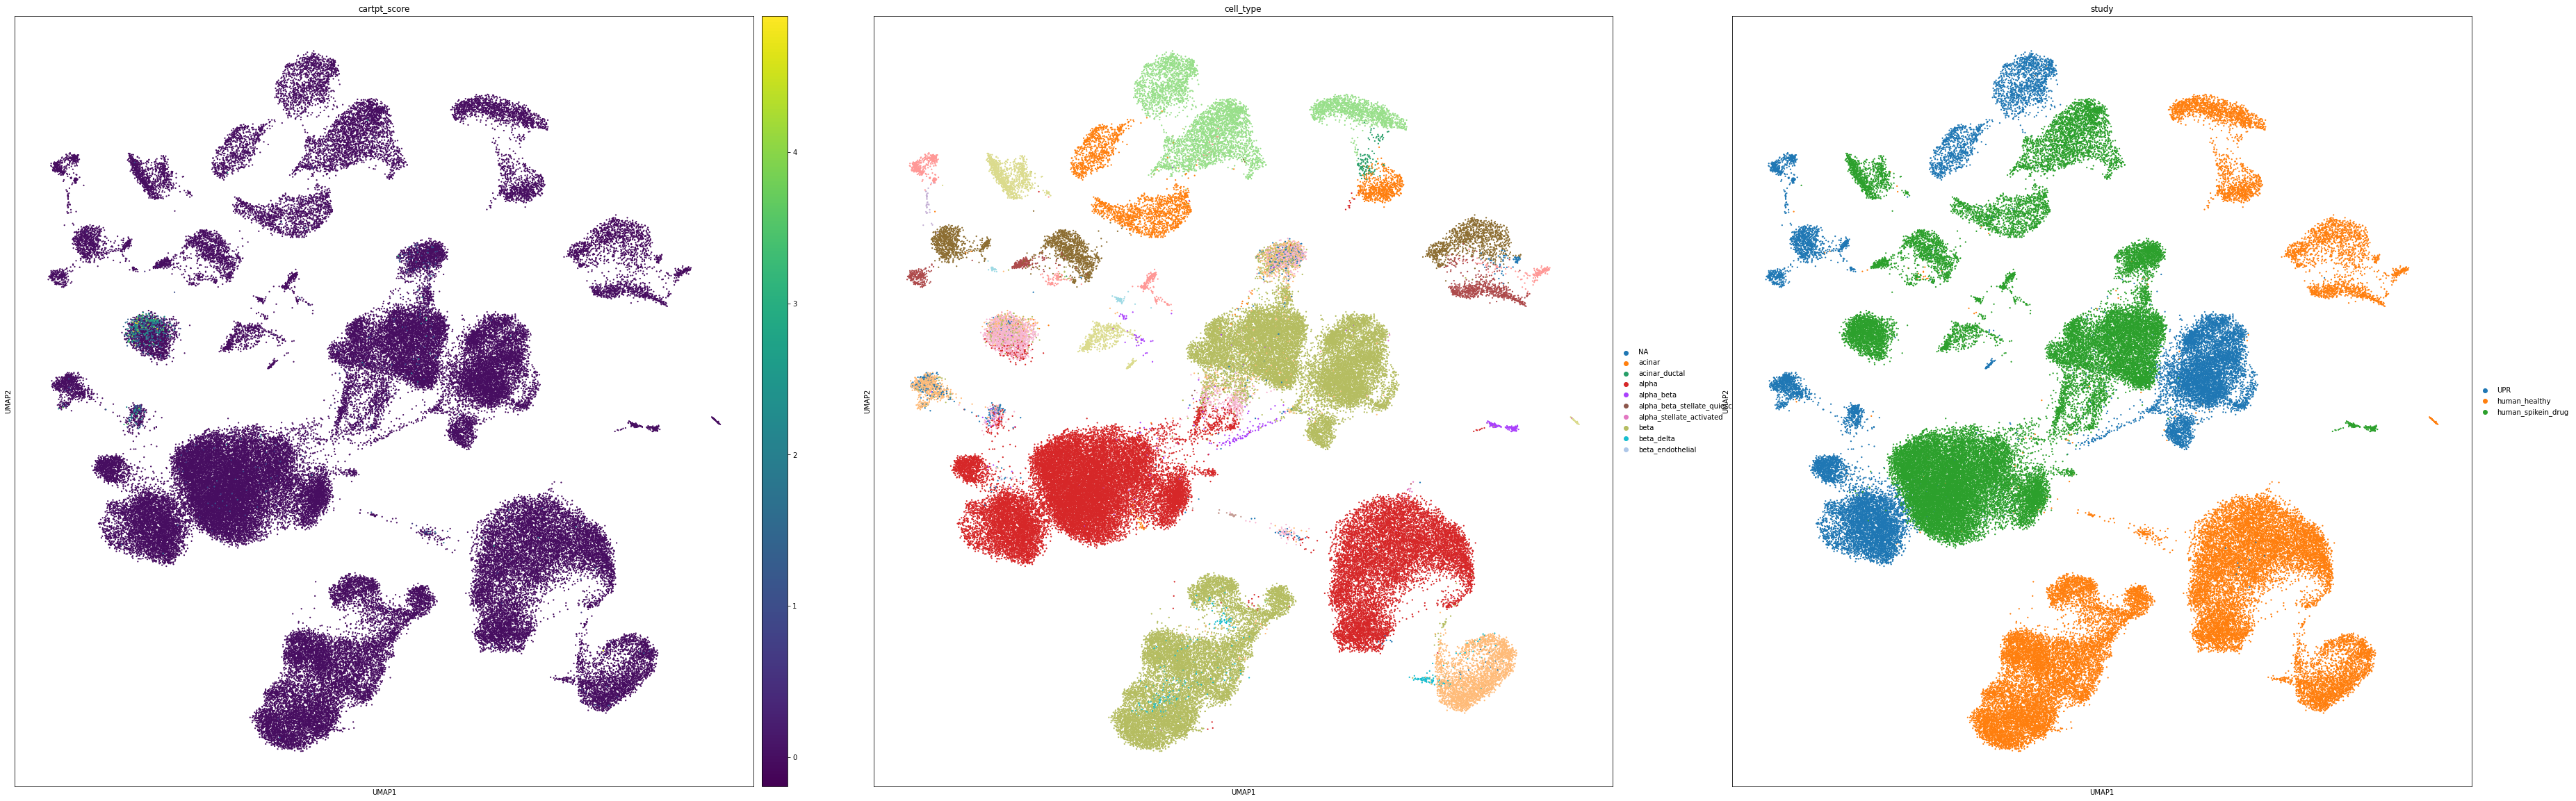

In [71]:
rcParams['figure.figsize'] = (20, 20)
sc.pl.umap(adata, size=20, color=['cartpt_score', 'cell_type', 'study'])

In [66]:
sc.pp.neighbors(adata_beta)
sc.tl.umap(adata_beta)

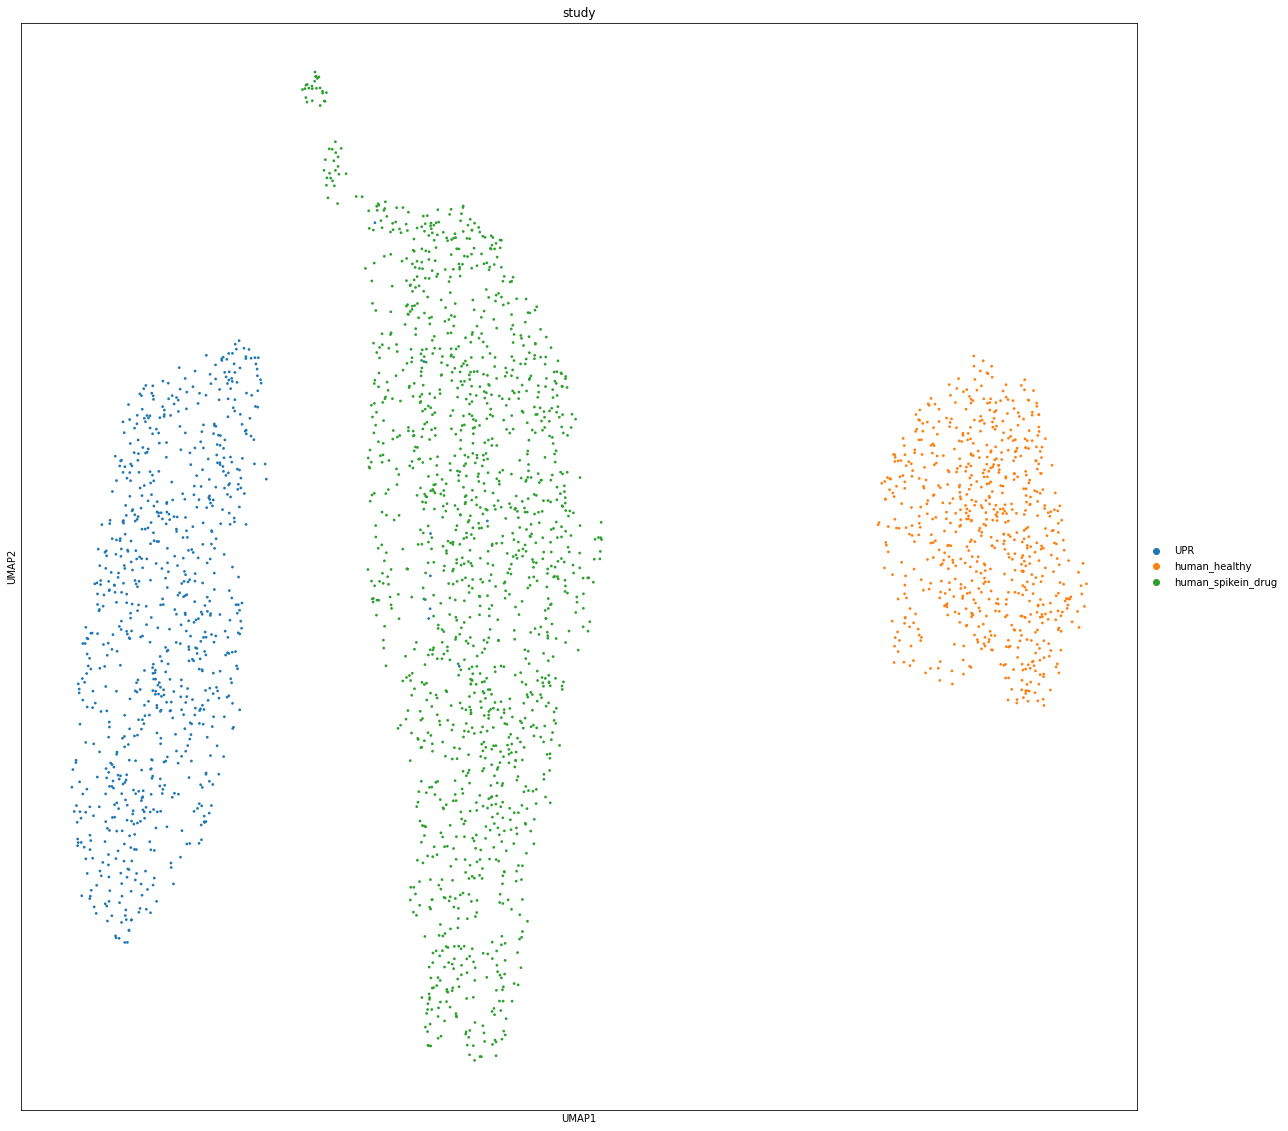

In [70]:
rcParams['figure.figsize'] = (20, 20)
sc.pl.umap(adata_beta, size=30, color='study')